<a href="https://colab.research.google.com/github/1712307/ImageProcessingAtUniversity/blob/master/Fourier_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Requirement
Run on Google Colab


Upload a file image in to Files and rename fileName


Should choose low-resolution images (64x64 pixel)

In [0]:
fileName = '4input.png' #rename it

# Code

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import time
import statistics as stt

In [0]:
def normalize(img, newMin, newMax):
    mini = np.min(img)
    maxi = np.max(img)
    return (img - mini)*(newMax - newMin)/(maxi - mini) - newMin

###Fourier transform (FT) (F(u, v))

In [0]:
# def FT(img): # use Euler 
#     M = img.shape[0]
#     N = img.shape[1]
#     aTempConstant = -2*np.pi

#     R = np.zeros((M, N), dtype=np.float64)
#     I = np.zeros((M, N), dtype=np.float64)
#     for u in range(M):
#         #print(u)
#         print (str(u) + '/' + str(M))
        
#         tempfactor_udM = aTempConstant * u / float(M)

#         for v in range (N):
#             tempfactor_vdN = aTempConstant * v / float(N)

#             for x in range(M):
#                 for y in range(N):
#                     #pha = aTempConstant*(u*x/float(M) + v*y/float(N))
#                     pha = tempfactor_udM * x + tempfactor_vdN * y

#                     R[u, v] += img[x, y] * np.cos(pha)
#                     I[u, v] += img[x, y] * np.sin(pha)
#     #R /= M*N
#     #I /= M*N
#     return R, I

def magnitude(F):
    magI = np.sqrt(np.power(F.real, 2) + np.power(F.imag, 2))
    
    matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
    cv2.add(matOfOnes, magI, magI) #  switch to logarithmic scale
    cv2.log(magI, magI)
    
    magI_rows, magI_cols = magI.shape
    # crop the spectrum, if it has an odd number of rows or columns
    #magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
    cx = int(magI_rows/2)
    cy = int(magI_cols/2)
    q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
    q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
    q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
    q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right
    tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
    magI[0:cx, 0:cy] = q3
    magI[cx:cx + cx, cy:cy + cy] = tmp
    tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
    magI[cx:cx + cx, 0:cy] = q2
    magI[0:cx, cy:cy + cy] = tmp
    
    magI = normalize(magI, 0, 1)
    
    #print(magI)
    return magI

def phase(F):
    phase = np.arctan(F.imag/F.real)
    phase = normalize(phase, 0, 1)
    #print(phase)
    return phase

In [0]:
def FT(img):
    M = img.shape[0]
    N = img.shape[1]

    F = np.zeros((M, N), dtype=complex)
    for u in range(M):
        #print(u)
        print (str(u) + '/' + str(M))
        
        for v in range (N):
            for x in range(M):
                for y in range(N):
                    F[u, v] += img[x, y] * np.exp(-2j*np.pi*(u*x/M + v*y/N))
    return F

###Filter (H(u, v)F(u, v))

In [0]:
def Ideal_Lowpass_Filters(M, N, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D <= D0:
                H[u, v] = 1
            else:
                H[u, v] = 0
    return H

def Ideal_Highpass_Filters(M, N, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D <= D0:
                H[u, v] = 0
            else:
                H[u, v] = 1
    return H

In [0]:
def Butterworth_Lowpass_Filters(M, N, n, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D == 0:
                D = 1
            H[u, v] = 1 / float(1 + (D / float(D0))**(2*n))

    return H

def Butterworth_Highpass_Filters(M, N, n, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D == 0:
                D = 1
            H[u, v] = 1 / float(1 + (D0 / float(D))**(2*n))

    return H

In [0]:
def Gaussian_Lowpass_Filters(M, N, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            H[u, v] = np.exp(-(D**2)/(2*(D0**2)))
    return H

def Gaussian_Highpass_Filters(M, N, D0):
    H = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            H[u, v] = 1 - np.exp(-(D**2)/(2*(D0**2)))

    return H

In [0]:
def Laplacian_in_Frequency_Domain(M, N):
    # chưa hoàn thành
    return null

###Inverse Fourier transform (IFT) (g(x, y))

In [0]:
def iFT(R, I): # use Euler 
    M = R.shape[0]
    N = R.shape[1]
    aTempConstant = 2*np.pi

    fR = np.zeros((M, N), dtype= float)
    fI = np.zeros((M, N), dtype= float)
    for x in range(M):
        #print(x)
        print (str(x) + '/' + str(M))

        tempfactor_xdM = aTempConstant * x / float(M)

        for y in range (N):
            tempfactor_ydN = aTempConstant * y / float(N)

            for u in range(M):
                for v in range(N):
                    pha = tempfactor_xdM * u + tempfactor_ydN * v
                    sin = np.sin(pha)
                    cos = np.cos(pha)
                    fR[x, y] += R[u, v] * cos - I[u, v] * sin
                    fI[x, y] += R[u, v] * sin + I[u, v] * cos
    fR /= M*N
    fI /= M*N
    return fR, fI

def iFT2(F):
    M = F.shape[0]
    N = F.shape[1]

    f = np.zeros((M, N), dtype= complex)
    for x in range(M):
        #print(x)
        print (str(x) + '/' + str(M))

        for y in range (N):
            for u in range(M):
                for v in range(N):
                    f += F[u, v]*np.exp(2j*np.pi*(u*x/M + v*y/N))
    f /= M*N
    return f

#Run a sample

###Initialize (f(u, v))

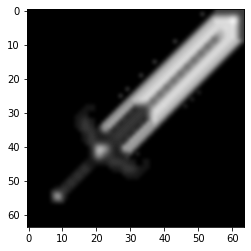

In [0]:
img=cv2.imread(fileName,cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', interpolation='bicubic')
plt.show()

###Fourier transform (FT) (F(u, v))

In [0]:
F = FT(img)

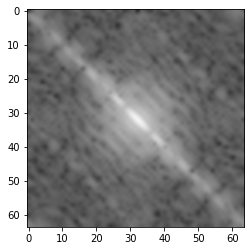

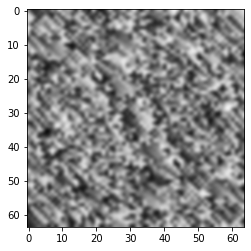

In [0]:
plt.imshow(magnitude(F), cmap='gray', interpolation='bicubic')
plt.show()
plt.imshow(phase(F), cmap='gray', interpolation='bicubic')
plt.show()

###Filter (H(u, v)F(u, v))

In [0]:
# chọn bộ lọc
# Ideal_Lowpass_Filters
# Butterworth_Lowpass_Filters
# Gaussian_Lowpass_Filters
#
# Ideal_Highpass_Filters
# Butterworth_Highpass_Filters
# Gaussian_Highpass_Filters
#


hf = F * Gaussian_Lowpass_Filters(img.shape[0], img.shape[1], 32) # chọn bộ lọc

In [0]:
Gaussian_Lowpass_Filters(img.shape[0], img.shape[1], 32)

array([[0.36787944+0.j, 0.3793719 +0.j, 0.39084152+0.j, ...,
        0.40226487+0.j, 0.39084152+0.j, 0.3793719 +0.j],
       [0.3793719 +0.j, 0.39122339+0.j, 0.40305131+0.j, ...,
        0.41483152+0.j, 0.40305131+0.j, 0.39122339+0.j],
       [0.39084152+0.j, 0.40305131+0.j, 0.41523683+0.j, ...,
        0.42737319+0.j, 0.41523683+0.j, 0.40305131+0.j],
       ...,
       [0.40226487+0.j, 0.41483152+0.j, 0.42737319+0.j, ...,
        0.43986428+0.j, 0.42737319+0.j, 0.41483152+0.j],
       [0.39084152+0.j, 0.40305131+0.j, 0.41523683+0.j, ...,
        0.42737319+0.j, 0.41523683+0.j, 0.40305131+0.j],
       [0.3793719 +0.j, 0.39122339+0.j, 0.40305131+0.j, ...,
        0.41483152+0.j, 0.40305131+0.j, 0.39122339+0.j]])

###Inverse Fourier transform (IFT) (g(x, y))

In [0]:
g_real, g_imag = iFT(hf.real, hf.imag)

0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64


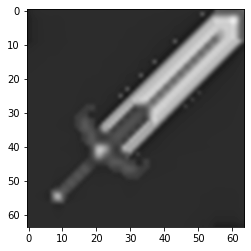

In [0]:
plt.imshow(g_real, cmap='gray', interpolation='bicubic')
plt.show()